# 분류 성능을 측정하기 위한 우도비

이 예제는 [class_likelihood_ratios](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.class_likelihood_ratios.html#sklearn.metrics.class_likelihood_ratios) 함수, 그러니까 이진 분류기의 예측력을 평가하기 위한 양과 음의 우도비를 계산하는 것을 시연한다. 이 메트릭(평가 지표)들은 평가 데이터셋의 범주의 비율과 독립적이라서 연구에 쓸 데이터가 목표 모집단과는 다른 범주의 비율을 가질 때 매우 유용하다.

흔한 사용례로서는 실험 대상의 범주는 거의 동등하지만 일반적인 모집단은 범주의 비율에 큰 격차가 있는 약학의 사례-대조 연구가 있다. 그러한 응용에서, 개체가 목표 조건에 맞을 사전확률은 유병율, 즉 특정 인구집단에서 특정 질병에 걸린 것으로 밝혀진 비율로 이해할 수 있다. 사후확률은 양성 검사 결과가 나왔을 때 실제로 그 질병이 존재할 확률을 나타낸다.

이 예제에서 우린 먼저 [CLass likelihood ratios](https://scikit-learn.org/stable/modules/model_evaluation.html#class-likelihood-ratios)에 의해 주어지는 사전 오즈와 사후 오즈의 연결에 대해 논의한다. 그리고 우린 몇 가지 통제된 시나리오에서 그들의 행태를 평가할 것이다. 마지막 섹션에선 그것들을 양성 범주의 유병율 함수로서 그래프로 나타낼 것이다.

In [1]:
# Authors:  Arturo Amor <david-arturo.amor-quiroz@inria.fr>
#           Olivier Grisel <olivier.grisel@ensta.org>

## 사전 vs. 사후 분석

질병의 간접적 바이오마커로 활용될 수도 있는 생리학적 측정치$X$가 있고 실제 질병 여부를 나타내는 $y$가 있다고 하자. 대부분의 인구집단은 그 질병이 없지만 일부는 있다.

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10_000,
                           weights=[0.9,0.1],
                           random_state=0)
print(f"Percentage of people carrying the disease: {100*y.mean():.2f}%")

Percentage of people carrying the disease: 10.37%


어떤 사람의 생리학적 측정치가 주어졌을 때 관심 질병이 있을지 진단하기 위해 기계학습 모형이 구축된다. 그 모형을 평가하기 위해선, 따로 분리된 평가 데이터셋에서 그것의 성능을 평가해야 한다.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

그런 다음 진단 모형을 적합시킨 후 질병 진단 도구로서 이 분류기가 유용한지 평가하기 위해 양의 우도비를 계산한다.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import class_likelihood_ratios

estimator = LogisticRegression().fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pos_LR, neg_LR = class_likelihood_ratios(y_test, y_pred)
print(f"LR+ :{pos_LR:.3f}")

LR+ :12.617


양의 우도비가 1.0보다 훨씬 크므로, 이 기계학습 기반의 진단 도구는 유용하다. 
> 출력 결과는 평가 데이터에서 양성으로 예측했을 때 실제로도 양성일 사후 오즈가 사전오즈보다 약 12배 더 크다는 뜻이다.

## 우도비의 교차 검증

몇몇 특정 상황에서 우도비에 대한 측도의 변동성을 보도록 하자.

In [15]:
import pandas as pd

def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    pos_lr, neg_lr = class_likelihood_ratios(y, y_pred, raise_warning=False)
    return {"positive_likelihood_ratio":pos_lr,
    "negative_likelihood_ratio":neg_lr}

def extract_score(cv_results):
    lr = pd.DataFrame(
        {
            "positive":cv_results["test_positive_likelihood_ratio"],
            "negative":cv_results["test_negative_likelihood_ratio"]
        }
    )
    return lr.aggregate(["mean", "std"])

먼저 이전 섹션에서처럼 기본 하이퍼파라미터를 가진 [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) 모형을 검증해보자.

In [8]:
from sklearn.model_selection import cross_validate

estimator=LogisticRegression()
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negetive
mean,16.661086,0.724702
std,4.383973,0.054045


사전 오즈보다 사후오즈가 16배 정도 높으므로 모형이 유용함을 확신할 수 있다.

대조적인 모형으로 훈련 세트의 평균 유병율과 유사한 오즈를 무작위로 출력하는 더미 모형을 생각해 보자.

In [9]:
from sklearn.dummy import DummyClassifier

estimator = DummyClassifier(strategy="stratified", random_state=1234)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negetive
mean,1.108843,0.986989
std,0.268147,0.034278


두 오즈비들이 전부 1.0에 가깝게 나왔으므로 이 분류기는 질병 감지에 쓸모없는 진단 도구이다.

다른 더미 도형으로는 가장 흔한 경우, 이 예제에선 질병이 없는 경우로 예측하는 것이 있다.

In [10]:
estimator = DummyClassifier(strategy="most_frequent")
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negetive
mean,NaN,1.0
std,NaN,0.0


양성 예측이 없는 건 참 양성이나 거짓 양성 둘 다 없기 때문에 발생한 일로, 이 경우 애초에 양성 우도비 자체가 정의되지 않는다. 이는 우도비 값이 무한대이기 때문이 전혀 아니므로 그렇게 해석해선 안 된다. 설령 그런 경우라고 하더라도 [class_likelihood_ratios](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.class_likelihood_ratios.html#sklearn.metrics.class_likelihood_ratios) 함수는 기본적으로 __nan__ 을 반환한다. 음성 우도비는 이 모형을 제거해야 함을 보여준다.

비슷한 시나리오가 크게 불균형적이고 표본 수가 적은 데이터에서 발생할 수 있다. 몇몇 폴드에선 질병이 없는 표본이 발생하고, 그래서 그것들은 평가 시에도 양성 예측 자체를 아예 하지 않을 것이다. 수학적으로 이는 무한한 양의 우도비를 만드는데, 이걸 모형이 양성을 완벽하게 식별하는 것으로 해석해선 안 된다. 그런 사건은 추정된 우도비의 분산을 크게 만들지만, 여전히 사전오즈의 증가로 해석될 수가 있다.

In [11]:
estimator = LogisticRegression()
X, y = make_classification(n_samples=300, weights=[0.9, 0.1],
                           random_state=0)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negetive
mean,17.8000,0.373333
std,8.5557,0.235430


## 유병율에 대한 불변성

우도비는 질병 유병률과 독립적이며, 클래스 불균형이 있더라도 동일한 모델이 적용되는 한 여러 인구 집단 간에 외삽될 수 있다. 아래의 그래프에서 결정 경계가 일정하다는 점에 주목하자. (불균형 클래스의 경계 결정에 대한 연구는 [SVM: Separating hyperplane for unbalanced classes](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)을 참조).

유병율 50%인 사례-대조 연구에 로지스틱 회귀 기반의 모형을 훈련시켜 보자. 그리고 다양한 유병율을 가진 모집단에 대해 평가될 것이다. 데이터를 생성하는 작업은 [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) 함수가 해줄 것이다. 레이블$1$은 양성을, 레이블$0$은 음성을 의미한다.

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

populations = defaultdict(list)
common_params = {
    "n_samples":10_000,
    "n_features":2,
    "n_informative":2,
    "n_redundant":0,
    "random_state":0
}
weights = np.linspace(0.1, 0.8, 6)
weights = weights[::-1]

In [16]:
X, y = make_classification(**common_params, weights=[0.5,0.5])
estimator = LogisticRegression().fit(X, y)
lr_base = extract_score(cross_validate(estimator, X, y, 
                                       scoring=scoring, cv=10))
pos_lr_base, pos_lr_base_std = lr_base["positive"].values
neg_lr_base, neg_lr_base_std = lr_base["negative"].values

이제 결정 경계를 시각화하자. 선형 모형의 결정 경계에 대해 더 잘 이해하기 위해 원 데이터의 일부만 포함할 것이다.

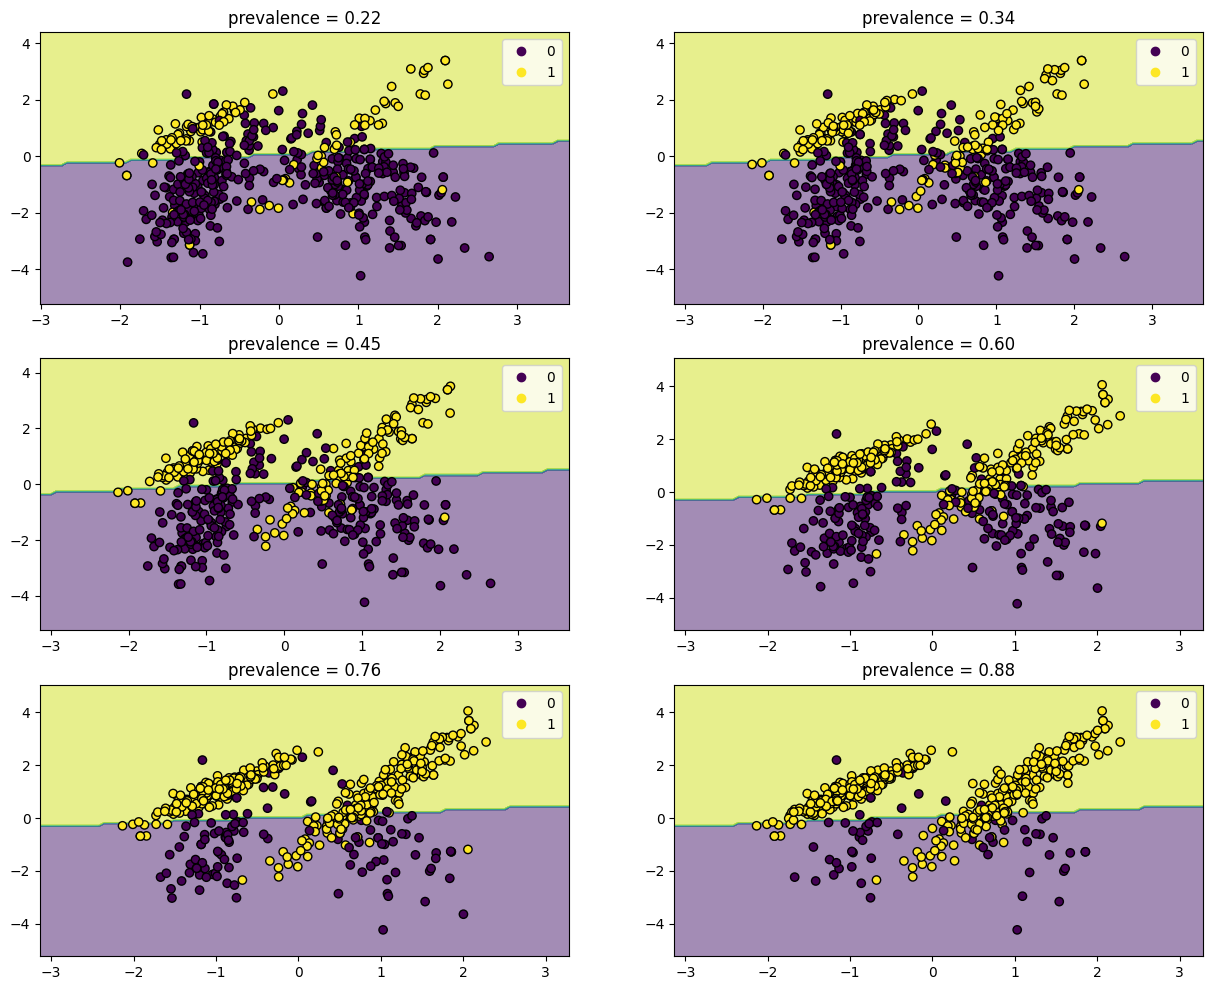

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
for ax, (n, weight) in zip(axs.ravel(), enumerate(weights)):
    X, y = make_classification(
        **common_params,
        weights=[weight, 1-weight]
    )
    prevalence = y.mean()
    populations["prevalence"].append(prevalence)
    populations["X"].append(X)
    populations["y"].append(y)

    # 표본 축소(down-sampling)
    rng = np.random.RandomState(1)
    plot_indices = rng.choice(np.arange(X.shape[0]), size=500, replace=True)
    X_plot, y_plot = X[plot_indices], y[plot_indices]

    # 다양한 유병율에 따른 모형의 결정 경계들을 시각화
    disp = DecisionBoundaryDisplay.from_estimator(
    estimator, X_plot, response_method="predict",alpha=0.5,ax=ax
    )
    scatter=disp.ax_.scatter(X_plot[:,0],X_plot[:,1],c=y_plot,edgecolor="k")
    disp.ax_.set_title(f"prevalence = {y_plot.mean():.2f}")
    disp.ax_.legend(*scatter.legend_elements())

이제 부트스트래핑을 위한 함수를 정의하자.

In [19]:
def scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=100):
    results_for_prevalence = defaultdict(list)
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(
            np.arange(X.shape[0]), size=X.shape[0], replace=True
        )
        for key, value in scoring(
            estimator, X[bootstrap_indices], y[bootstrap_indices]
        ).items():
            results_for_prevalence[key].append(value)
    return pd.DataFrame(results_for_prevalence)

이제 기본 모형을 부트스트래핑을 사용해 각각의 유병율에 대해 평가하자.

In [23]:
results = defaultdict(list)
n_bootstrap = 100
rng = np.random.default_rng(seed=0)

for prevalence, X, y in zip(
    populations["prevalence"], populations["X"], populations["y"]
):
    results_for_prevalence = scoring_on_bootstrap(
        estimator, X, y, rng, n_bootstrap=n_bootstrap
    )
    results["prevalence"].append(prevalence)
    results["metrics"].append(
    results_for_prevalence.aggregate(["mean","std"]).unstack()
    )

results = pd.DataFrame(results["metrics"], index=results["prevalence"])
results.index.name = "prevalence"
results

positive_likelihood_ratio           negative_likelihood_ratio  \
                                mean       std                      mean   
prevalence                                                                 
0.2039                      4.507943  0.113516                  0.207667   
0.3419                      4.443238  0.125140                  0.198766   
0.4809                      4.421087  0.123828                  0.192913   
0.6196                      4.409717  0.164009                  0.193949   
0.7578                      4.334795  0.175298                  0.189267   
0.8963                      4.197666  0.238955                  0.185654   
0.2039                      4.505850  0.106670                  0.208340   
0.3419                      4.461680  0.125949                  0.196695   
0.4809                      4.432984  0.119926                  0.193192   
0.6196                      4.426552  0.148653                  0.194404   
0.7578                      4.327325  0.196518                  0.189548   
0.8963                      4.176698  0.275443                  0.185694   

                      
                 std  
prevalence            
0.2039      0.009778  
0.3419      0.008915  
0.4809      0.006360  
0.6196      0.005861  
0.7578      0.005840  
0.8963      0.005027  
0.2039      0.010112  
0.3419      0.007581  
0.4809      0.006209  
0.6196      0.005867  
0.7578      0.005494  
0.8963      0.005115

아래의 그래프에서 서로 다른 유병율 하에서 계산된 우도비들이 균형적인 범주들에서 계산된 $1\sigma$를 고려할 때 실제로 상수임을 볼 수 있다.

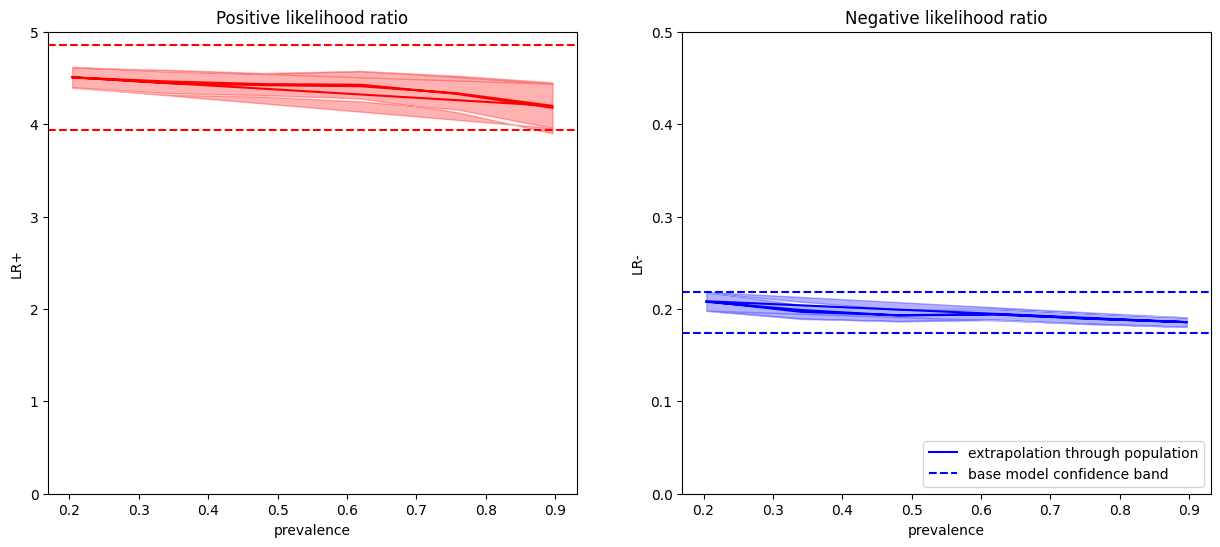

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
results["positive_likelihood_ratio"]["mean"].plot(
    ax=ax1, color="r", label="extrapolation through populations"
)
ax1.axhline(y=pos_lr_base + pos_lr_base_std, color="r", linestyle="--")
ax1.axhline(
    y=pos_lr_base - pos_lr_base_std,
    color="r",
    linestyle="--",
    label="base model confidence band"
)
ax1.fill_between(
    results.index,
    results["positive_likelihood_ratio"]["mean"]
    - results["positive_likelihood_ratio"]["std"],
    results["positive_likelihood_ratio"]["mean"]
    + results["positive_likelihood_ratio"]["std"],
    color="r",
    alpha=0.3
)
ax1.set(
    title="Positive likelihood ratio",
    ylabel="LR+",
    ylim=[0,5]
)

ax2 = results["negative_likelihood_ratio"]["mean"].plot(
    ax=ax2, color="b", label="extrapolation through population"
)
ax2.axhline(y=neg_lr_base + neg_lr_base_std, color="b", linestyle="--")
ax2.axhline(
    y=neg_lr_base - neg_lr_base_std,
    color="b",
    linestyle="--",
    label="base model confidence band"
)
ax2.fill_between(
    results.index,
    results["negative_likelihood_ratio"]["mean"]
    - results["negative_likelihood_ratio"]["std"],
    results["negative_likelihood_ratio"]["mean"]
    + results["negative_likelihood_ratio"]["std"],
    color="b",
    alpha=0.3
)
ax2.set(
    title="Negative likelihood ratio",
    ylabel="LR-",
    ylim=[0,0.5]
)
ax2.legend(loc="lower right")
plt.show()